Example to see if we can isolate control variables in an XGBoost model and re-introduce them later. We can also test constraining the depth of controls interactions too. 

In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.linear_model import GammaRegressor
import matplotlib
import matplotlib.pyplot as plt


plt.style.use("ggplot")

In [2]:
data = datasets.load_boston()
X = data["data"]
y = data["target"]

/Users/paulrobshannon/anaconda3/envs/control/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [4]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

params = {"max_depth": 3, "eta": 1, "objective": "reg:squarederror"}

params_constrained = params.copy()
# Use nested list to define feature interaction constraints
params_constrained["interaction_constraints"] = "[[0], [1], [2, 3], [2, 4], [3, 4], [5, 6, 7, 8, 9, 10, 11, 12]]"
# Features 0, 1, 2, 3, 4 are control variables in this example
# Features 0 and 1 are not allowed to interact with any other feature
# Features 1, 3 are allowed to interact with one another but with no other feature
# Features 2 and 3 are allowed to interact with each other but with no other feature
# Features 2 and 4 are allowed to interact with each other but with no other feature
# Features 3 and 4 are allowed to interact with each other but with no other feature
# Features 5:12 are allowed to interact with each other but not with features 0:4


watchlist = [(dtest, "eval"), (dtrain, "train")]

model_with_constraints = xgb.train(params_constrained, dtrain,
                                   num_boost_round = 1000,
                                   evals=watchlist,
                                   early_stopping_rounds = 10,
                                   verbose_eval=False)


# # specify validations set to watch performance
# watchlist = [(dtest, "eval"), (dtrain, "train")]
# # number of boosting rounds
# num_round = 2
# # bst = xgb.train(params_constrained, dtrain, num_boost_round=num_round, evals=watchlist, silent=1)

# run prediction
preds = model_with_constraints.predict(dtest)
labels = dtest.get_label()

In [5]:
model_with_constraints.best_iteration

277

Let's print out a few trees containing our constrained features to see if this holds.

0:[f0<0.0478000008] yes=1,no=2,missing=1
	1:[f0<0.0349100009] yes=3,no=4,missing=3
		3:[f0<0.0313149989] yes=7,no=8,missing=7
			7:leaf=-0.441087186
			8:leaf=1.21416187
		4:[f0<0.0354399979] yes=9,no=10,missing=9
			9:leaf=-1.84401703
			10:leaf=-0.652704477
	2:[f0<0.176440001] yes=5,no=6,missing=5
		5:[f0<0.143429995] yes=11,no=12,missing=11
			11:leaf=0.294395417
			12:leaf=1.32359374
		6:[f0<0.229479998] yes=13,no=14,missing=13
			13:leaf=-1.04355061
			14:leaf=-0.0285211038



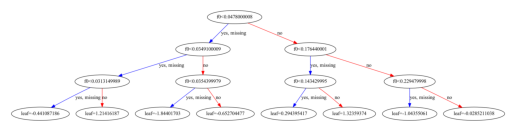

0:[f0<13.6001492] yes=1,no=2,missing=1
	1:[f0<9.36475945] yes=3,no=4,missing=3
		3:[f0<6.46594] yes=7,no=8,missing=7
			7:leaf=0.054487966
			8:leaf=-0.581698537
		4:[f0<9.87001991] yes=9,no=10,missing=9
			9:leaf=2.27385116
			10:leaf=-0.0930746868
	2:[f0<23.1226501] yes=5,no=6,missing=5
		5:[f0<22.3241005] yes=11,no=12,missing=11
			11:leaf=-0.609402597
			12:leaf=-1.21276355
		6:[f0<24.5977516] yes=13,no=14,missing=13
			13:leaf=0.505275726
			14:leaf=-0.187707156



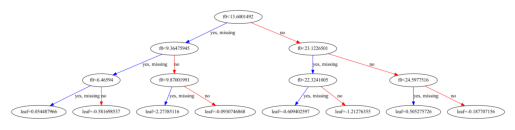

0:[f0<0.0263700001] yes=1,no=2,missing=1
	1:[f0<0.0234249998] yes=3,no=4,missing=3
		3:[f0<0.0195799991] yes=7,no=8,missing=7
			7:leaf=-0.273325831
			8:leaf=0.190710068
		4:leaf=-1.1929239
	2:[f0<9.94154549] yes=5,no=6,missing=5
		5:[f0<8.88753986] yes=9,no=10,missing=9
			9:leaf=0.0250649117
			10:leaf=0.496351421
		6:[f0<11.99965] yes=11,no=12,missing=11
			11:leaf=-0.506495059
			12:leaf=0.0140393572



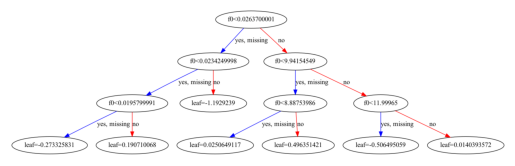

0:[f0<0.129949987] yes=1,no=2,missing=1
	1:[f0<0.114820004] yes=3,no=4,missing=3
		3:[f0<0.109930001] yes=7,no=8,missing=7
			7:leaf=-0.0561587512
			8:leaf=0.26392746
		4:[f0<0.124540001] yes=9,no=10,missing=9
			9:leaf=-0.296155304
			10:leaf=-0.758212388
	2:[f0<0.14952001] yes=5,no=6,missing=5
		5:[f0<0.143429995] yes=11,no=12,missing=11
			11:leaf=0.153568029
			12:leaf=1.20708847
		6:[f0<0.159060001] yes=13,no=14,missing=13
			13:leaf=-0.407461733
			14:leaf=0.0303337686



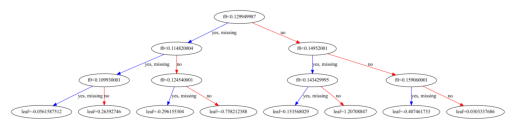

0:[f0<0.0390150025] yes=1,no=2,missing=1
	1:[f0<0.0296999998] yes=3,no=4,missing=3
		3:[f0<0.0207099989] yes=7,no=8,missing=7
			7:leaf=0.0784091949
			8:leaf=-0.288086474
		4:[f0<0.0308099985] yes=9,no=10,missing=9
			9:leaf=0.637383759
			10:leaf=0.231518492
	2:[f0<0.0437700003] yes=5,no=6,missing=5
		5:[f0<0.0431900024] yes=11,no=12,missing=11
			11:leaf=-0.140227452
			12:leaf=-0.500644684
		6:[f0<0.0453549996] yes=13,no=14,missing=13
			13:leaf=0.506325722
			14:leaf=-0.0120388642



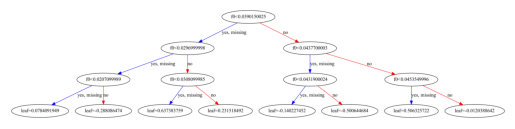

0:[f0<0.229479998] yes=1,no=2,missing=1
	1:[f0<0.220825002] yes=3,no=4,missing=3
		3:[f0<0.212850004] yes=7,no=8,missing=7
			7:leaf=-0.0250951052
			8:leaf=0.246916294
		4:leaf=-0.513535321
	2:[f0<0.284560025] yes=5,no=6,missing=5
		5:[f0<0.256510019] yes=9,no=10,missing=9
			9:leaf=0.0392864011
			10:leaf=0.401923001
		6:[f0<0.576815009] yes=11,no=12,missing=11
			11:leaf=-0.0697717667
			12:leaf=0.037730407



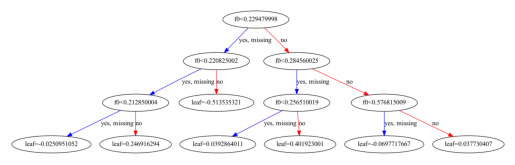

0:[f1<26.5] yes=1,no=2,missing=1
	1:[f1<6.25] yes=3,no=4,missing=3
		3:leaf=0.0123694949
		4:[f1<23.5] yes=7,no=8,missing=7
			7:leaf=0.0551040322
			8:leaf=0.129174352
	2:[f1<33.5] yes=5,no=6,missing=5
		5:leaf=-0.291058928
		6:[f1<53.75] yes=9,no=10,missing=9
			9:leaf=0.00339097972
			10:leaf=-0.104136467



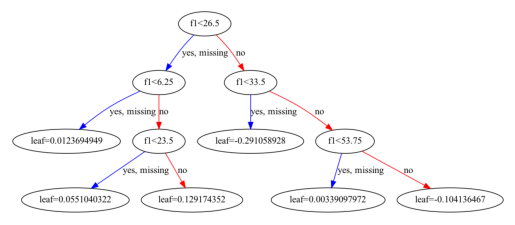

0:[f0<11.99965] yes=1,no=2,missing=1
	1:[f0<8.22433472] yes=3,no=4,missing=3
		3:[f0<5.82257986] yes=7,no=8,missing=7
			7:leaf=-0.00351011916
			8:leaf=0.103826411
		4:[f0<9.36475945] yes=9,no=10,missing=9
			9:leaf=-0.246129781
			10:leaf=-0.0361893959
	2:[f0<16.33605] yes=5,no=6,missing=5
		5:[f0<15.5741501] yes=11,no=12,missing=11
			11:leaf=0.0958532318
			12:leaf=0.280870438
		6:[f0<21.3836498] yes=13,no=14,missing=13
			13:leaf=-0.0948872566
			14:leaf=0.128638014



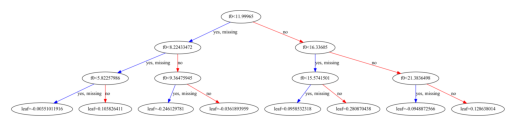

0:[f1<72.5] yes=1,no=2,missing=1
	1:[f1<53.75] yes=3,no=4,missing=3
		3:[f1<42.5] yes=7,no=8,missing=7
			7:leaf=-0.00655559963
			8:leaf=0.0784696564
		4:[f1<65] yes=9,no=10,missing=9
			9:leaf=-0.0690676346
			10:leaf=-0.176102325
	2:[f1<81.25] yes=5,no=6,missing=5
		5:[f1<77.5] yes=11,no=12,missing=11
			11:leaf=0.210373566
			12:leaf=0.0982679874
		6:[f1<92.5] yes=13,no=14,missing=13
			13:leaf=0.00929205772
			14:leaf=-0.0362116508



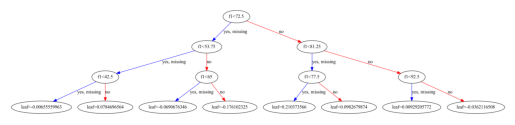

0:[f0<24.0209999] yes=1,no=2,missing=1
	1:[f0<12.66115] yes=3,no=4,missing=3
		3:[f0<5.36709499] yes=7,no=8,missing=7
			7:leaf=0.00566167571
			8:leaf=-0.0461483821
		4:[f0<19.2915497] yes=9,no=10,missing=9
			9:leaf=0.107787095
			10:leaf=-0.0172425117
	2:[f0<24.9239006] yes=5,no=6,missing=5
		5:leaf=-0.207980797
		6:[f0<26.8509502] yes=11,no=12,missing=11
			11:leaf=0.0337975025
			12:leaf=-0.0971271545



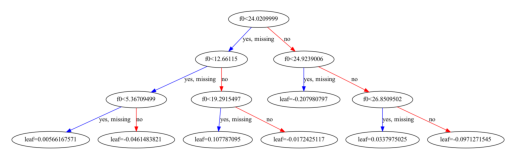

In [6]:
counter = 0
dump = model_with_constraints.get_dump()

for i in range(0, len(dump)):
    if counter == 10:
        break
    
    if any(x in dump[i] for x in ["f0", "f1<"]):
        counter += 1
        print(dump[i])
        xgb.plot_tree(model_with_constraints, num_trees = i)
        plt.show()

Perfect, we see only f0 with itself and f1 with itself. Now let's check f2 which is allowed to interact with f3 and f4, but not f3 and f4 together.

0:[f2<7.625] yes=1,no=2,missing=1
	1:[f4<0.44749999] yes=3,no=4,missing=3
		3:[f2<2.01499987] yes=7,no=8,missing=7
			7:leaf=0.506406426
			8:leaf=-0.0233331993
		4:[f4<0.50150001] yes=9,no=10,missing=9
			9:leaf=-0.726776481
			10:leaf=-0.0290303081
	2:[f2<8.00500011] yes=5,no=6,missing=5
		5:leaf=1.79519498
		6:[f3<0.5] yes=11,no=12,missing=11
			11:leaf=-0.0016265593
			12:leaf=0.788587093



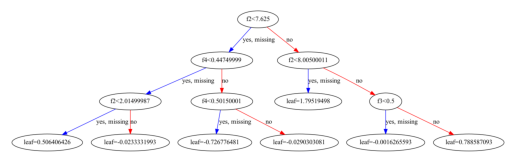

0:[f4<0.656999946] yes=1,no=2,missing=1
	1:[f4<0.583500028] yes=3,no=4,missing=3
		3:[f4<0.582000017] yes=7,no=8,missing=7
			7:leaf=0.0181393716
			8:leaf=-0.932793617
		4:[f4<0.601000011] yes=9,no=10,missing=9
			9:leaf=0.417904049
			10:leaf=0.122516178
	2:[f4<0.715499997] yes=5,no=6,missing=5
		5:[f3<0.5] yes=11,no=12,missing=11
			11:leaf=-0.296419024
			12:leaf=0.266975403
		6:[f4<0.754999995] yes=13,no=14,missing=13
			13:leaf=0.237579897
			14:leaf=-0.125674695



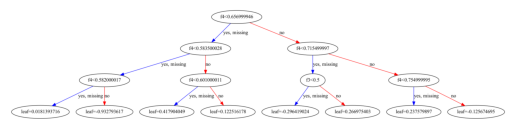

0:[f4<0.820500016] yes=1,no=2,missing=1
	1:[f4<0.728999972] yes=3,no=4,missing=3
		3:[f2<2.01499987] yes=7,no=8,missing=7
			7:leaf=0.126024246
			8:leaf=-0.00492748246
		4:[f3<0.5] yes=9,no=10,missing=9
			9:leaf=0.0836693794
			10:leaf=0.314296722
	2:[f3<0.5] yes=5,no=6,missing=5
		5:leaf=-0.0783968866
		6:leaf=-0.318000168



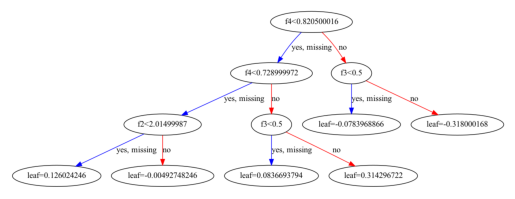

0:[f4<0.706499994] yes=1,no=2,missing=1
	1:[f4<0.651000023] yes=3,no=4,missing=3
		3:[f2<1.60500002] yes=7,no=8,missing=7
			7:leaf=-0.00718151452
			8:leaf=0.000381056714
		4:[f4<0.656999946] yes=9,no=10,missing=9
			9:leaf=-0.015601635
			10:leaf=-0.00386968791
	2:[f3<0.5] yes=5,no=6,missing=5
		5:[f4<0.754999995] yes=11,no=12,missing=11
			11:leaf=0.00715923309
			12:leaf=0.00479654176
		6:[f4<0.820500016] yes=13,no=14,missing=13
			13:leaf=0.00183010101
			14:leaf=-0.0167942047



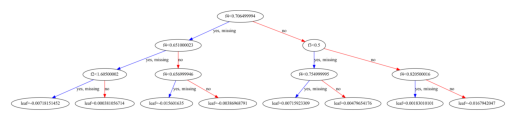

0:[f2<6.65999985] yes=1,no=2,missing=1
	1:[f3<0.5] yes=3,no=4,missing=3
		3:[f2<5.48000002] yes=7,no=8,missing=7
			7:leaf=-0.00134378928
			8:leaf=0.00062584877
		4:[f2<6.30499983] yes=9,no=10,missing=9
			9:leaf=-0.00694356626
			10:leaf=-0.000644683838
	2:[f4<0.521999955] yes=5,no=6,missing=5
		5:[f2<14.4799995] yes=11,no=12,missing=11
			11:leaf=0.00426801061
			12:leaf=-0.00694179535
		6:[f2<8.00500011] yes=13,no=14,missing=13
			13:leaf=-0.0089058876
			14:leaf=0.00043248001



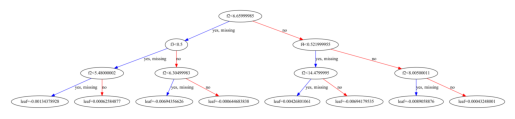

In [7]:
counter = 0
dump = model_with_constraints.get_dump()

for i in range(0, len(dump)):
    if counter == 5:
        break
    
    if "f2" and "f3" in dump[i]:
        counter += 1
        print(dump[i])
        xgb.plot_tree(model_with_constraints, num_trees = i)
        plt.show()

Predict the model as-is and also with dummy levels for the control variables. 

In [8]:
df = pd.DataFrame(X_train).add_prefix("f")
df_control = df.copy()
df["response"] = y_train
df["xgb_predicted"] = model_with_constraints.predict(dtrain)

for var in ["f0", "f1", "f2", "f3", "f4"]:
    df_control[var] = 1
    
df["xgb_predicted_controlled"] = model_with_constraints.predict(xgb.DMatrix(df_control))

Now we can fit this score in a linear model to see if the control variables still have an impact and can reinject the signal that has been removed.

In [9]:
glm = GammaRegressor()
glm_controlled_removed = GammaRegressor()
glm_controlled_added = GammaRegressor()

glm.fit(np.transpose(df["xgb_predicted"].to_numpy()).reshape(-1, 1), y_train)
glm_controlled_removed.fit(np.transpose(df["xgb_predicted_controlled"].to_numpy()).reshape(-1, 1), y_train)
glm_controlled_added.fit(df[["xgb_predicted_controlled", "f0", "f1", "f2", "f3", "f4"]].to_numpy(), y_train)

print(glm.coef_)
print(glm_controlled_removed.coef_)
print(glm_controlled_added.coef_)

[0.04119406]
[0.04130231]
[ 3.81301119e-02 -6.86394656e-03 -1.90171954e-05 -2.88313910e-03
  7.10273864e-04 -2.50249464e-03]


Plot each of the predictions to see if the errors reduce/enlarge depending on the effects being added/removed.

f0_
f1_
f2_
f3
f4_


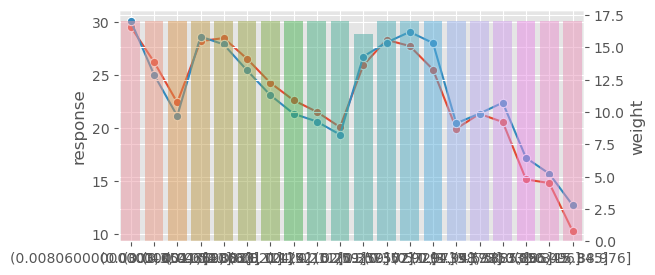

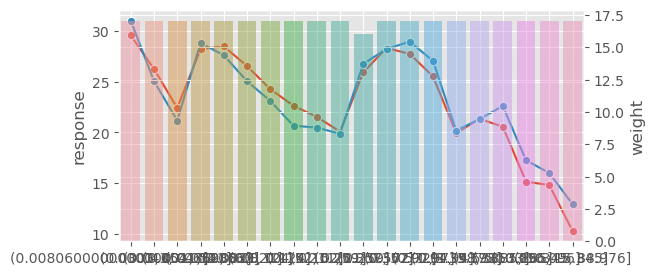

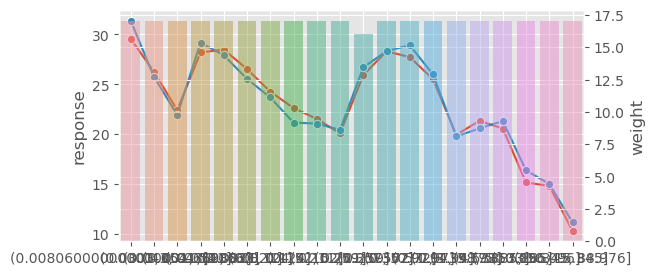

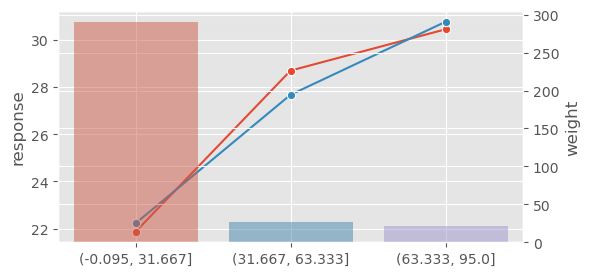

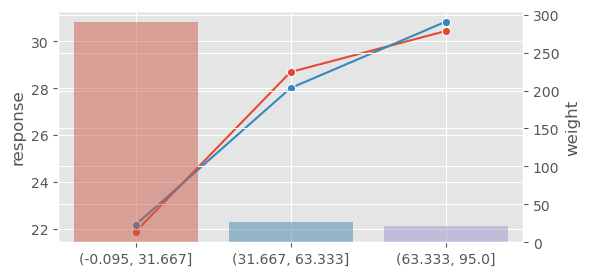

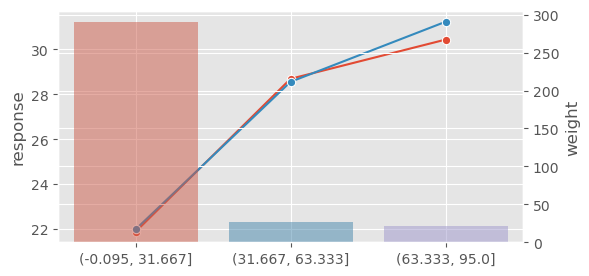

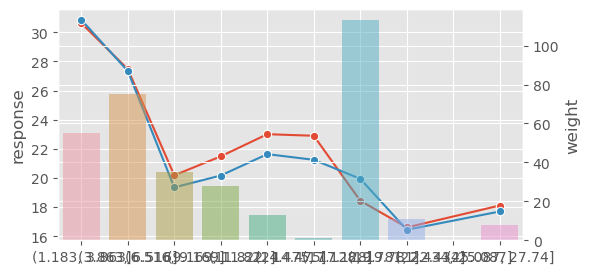

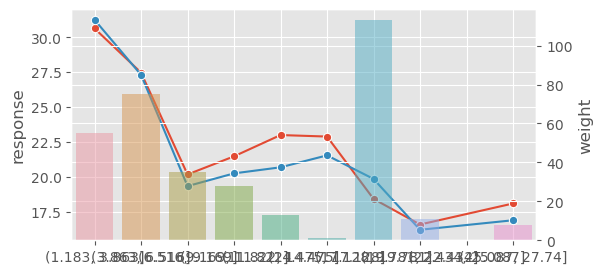

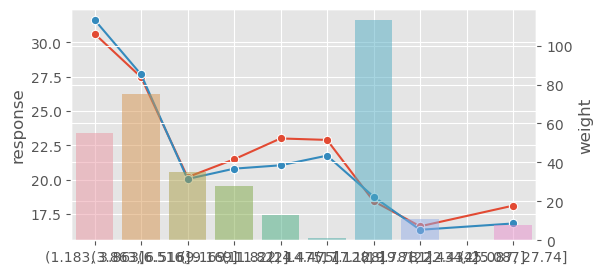

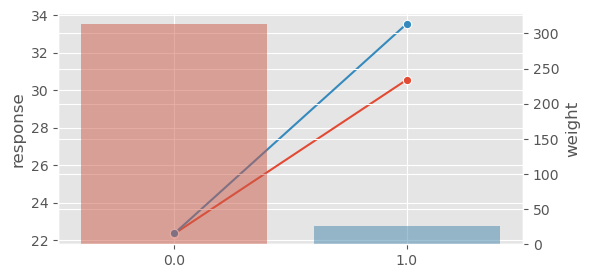

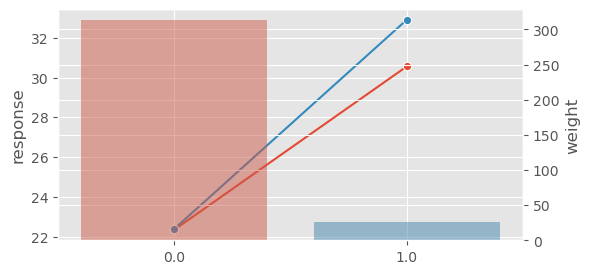

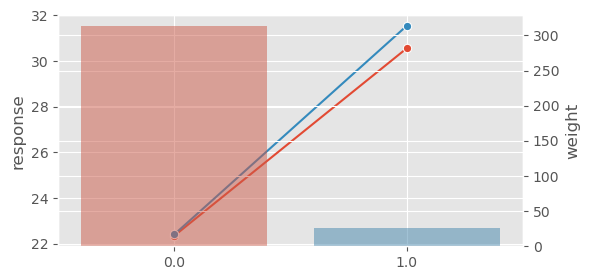

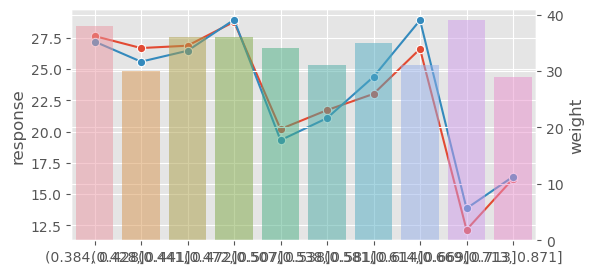

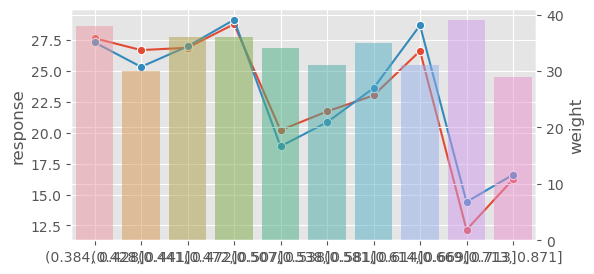

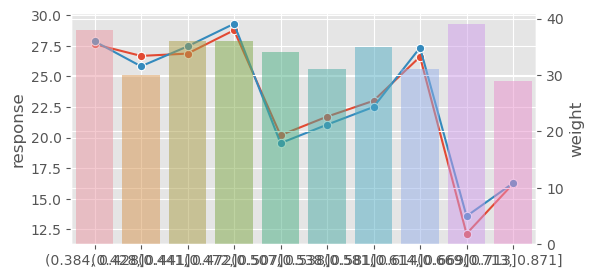

In [10]:
df["predicted_1"] = glm.predict(np.transpose(df["xgb_predicted"].to_numpy()).reshape(-1, 1))
df["predicted_2"] = glm_controlled_removed.predict(np.transpose(df["xgb_predicted_controlled"].to_numpy()).reshape(-1, 1))
df["predicted_3"] = glm_controlled_added.predict(df[["xgb_predicted_controlled", "f0", "f1", "f2", "f3", "f4"]].to_numpy())

df["f0_"] = pd.qcut(df["f0"], 20)
df["f1_"] = pd.cut(df["f1"], 3)
df["f2_"] = pd.cut(df["f2"], 10)
df["f4_"] = pd.qcut(df["f4"], 10)

for var in ["f0_", "f1_", "f2_", "f3", "f4_"]:
    print(var)
    plot_data = df.groupby(var).agg(weight = ("response", "size"),
                                response = ("response", "mean"),
                                 predicted1 = ("predicted_1", "mean"),
                                 predicted2 = ("predicted_2", "mean"),
                                   predicted3 = ("predicted_3", "mean")).reset_index()

    for i in ["predicted1", "predicted2", "predicted3"]:
        fig, ax1 = plt.subplots(figsize=(6, 3))
        sns.lineplot(data = plot_data["response"], marker = "o", sort = False, ax=ax1)
        sns.lineplot(data = plot_data[i], marker = "o", sort = False, ax=ax1)
        ax2 = ax1.twinx()

        sns.barplot(data = plot_data, x = var, y = "weight", alpha = 0.5, ax = ax2)